In [ ]:
import os
import pickle
import shutil
import joblib
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from operator import length_hint


In [ ]:
# Mount Google Drive to save models
drive.mount('/content/drive')

# Create a local directory to temporarily save models
os.makedirs('saved_models', exist_ok=True)

Mounted at /content/drive


### Load Data & Read Data

In [ ]:
path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")
file_path = os.path.join(path, 'credit_card_transactions.csv')
df = pd.read_csv(file_path)
print(df.head())


100%|██████████| 145M/145M [00:07<00:00, 20.4MB/s]

Extracting files...


   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      long city_pop  \
0    Banks      F                561 Perry Cove  ...  -81.1781     3495   
1     Gill      F  43039 Riley Greens Suite 393  ... -11

In [ ]:
# Check for missing values
for col in df.columns:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        print(f"'{col}' : {missing_count}")


'merch_zipcode' : 195973


In [ ]:
df.describe(include='all')

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
count,1.296675e+06,1296675,1.296675e+06,1296675,1296675,1.296675e+06,1296675,1296675,1296675,1296675,...,1.296675e+06,1.296675e+06,1296675,1296675,1296675,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.100702e+06
unique,NaN,1274791,NaN,693,14,NaN,352,481,2,983,...,NaN,NaN,494,968,1296675,NaN,NaN,NaN,NaN,NaN
top,NaN,2019-04-22 16:02:01,NaN,fraud_Kilback LLC,gas_transport,NaN,Christopher,Smith,F,864 Reynolds Plains,...,NaN,NaN,Film/video editor,1977-03-23,8f7c8e4ab7f25875d753b422917c98c9,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,4403,131659,NaN,26669,28794,709863,3123,...,NaN,NaN,9779,5636,1,NaN,NaN,NaN,NaN,NaN
mean,6.483370e+05,NaN,4.171920e+17,NaN,NaN,7.035104e+01,NaN,NaN,NaN,NaN,...,-9.022634e+01,8.882444e+04,NaN,NaN,NaN,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03,4.682575e+04
std,3.743180e+05,NaN,1.308806e+18,NaN,NaN,1.603160e+02,NaN,NaN,NaN,NaN,...,1.375908e+01,3.019564e+05,NaN,NaN,NaN,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02,2.583400e+04
min,0.000000e+00,NaN,6.041621e+10,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,...,-1.656723e+02,2.300000e+01,NaN,NaN,NaN,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00,1.001000e+03
25%,3.241685e+05,NaN,1.800429e+14,NaN,NaN,9.650000e+00,NaN,NaN,NaN,NaN,...,-9.679800e+01,7.430000e+02,NaN,NaN,NaN,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00,2.511400e+04
50%,6.483370e+05,NaN,3.521417e+15,NaN,NaN,4.752000e+01,NaN,NaN,NaN,NaN,...,-8.747690e+01,2.456000e+03,NaN,NaN,NaN,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00,4.586000e+04
75%,9.725055e+05,NaN,4.642255e+15,NaN,NaN,8.314000e+01,NaN,NaN,NaN,NaN,...,-8.015800e+01,2.032800e+04,NaN,NaN,NaN,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00,6.831900e+04


### Prepocessing

In [ ]:
# Handle missing values
df['merch_zipcode'] = df['merch_zipcode'].fillna(-1)  # Using -1 as a placeholder for missing values

In [ ]:
# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0','trans_date_trans_time', 'trans_num', 'unix_time', 'dob', 'first', 'last'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 16 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   merchant               1296675 non-null  object 
 2   category               1296675 non-null  object 
 3   amt                    1296675 non-null  float64
 4   gender                 1296675 non-null  object 
 5   city                   1296675 non-null  object 
 6   state                  1296675 non-null  object 
 7   zip                    1296675 non-null  int64  
 8   lat                    1296675 non-null  float64
 9   long                   1296675 non-null  float64
 10  city_pop               1296675 non-null  int64  
 11  job                    1296675 non-null  object 
 12  dob                    1296675 non-null  object 
 13  merch_lat              1296675 non-null  float64
 14  merch_long        

#### Feature Selection

In [ ]:
print(df.columns)

Index(['cc_num', 'merchant', 'category', 'amt', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'merch_lat',
       'merch_long', 'is_fraud', 'merch_zipcode'],
      dtype='object')


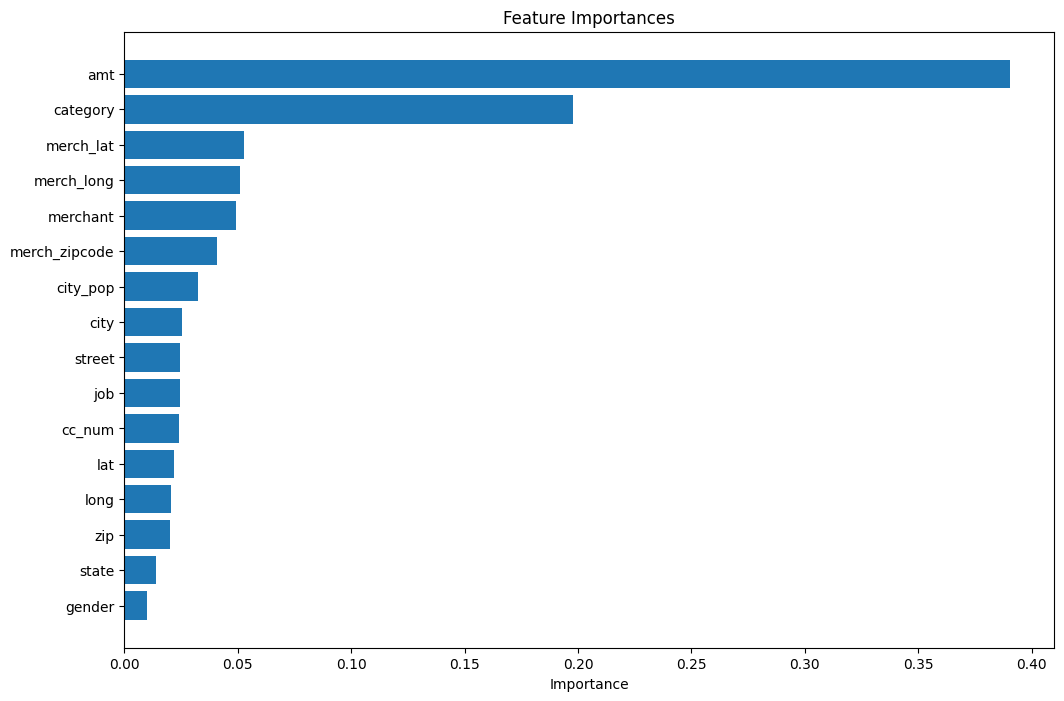

In [ ]:

# Extract feature importances using random forest
le = LabelEncoder()
categorical_columns = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'job']

for column in categorical_columns:
    df[column] = le.fit_transform(df[column].astype(str))

X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()


In [ ]:
# List of selected categorical and numeric columns
categorical = ['merchant', 'category', 'gender', 'city', 'state', 'job']
numeric=['amt', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', MinMaxScaler(), numeric)
        # Adjust numerical columns as needed
    ]
)

y = df['is_fraud']
X = df.drop(columns=['is_fraud'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### ML Model Training

- Unbalanced Dataset

In [ ]:
# Create pipeline
param_grids = {
    'logistic_regression': {
        'model__C': [0.1, 1.0, 10.0],
        'model__max_iter': [500, 1000]
    },
    'random_forest': {
        'model__n_estimators': [100, 200, 500],
        'model__max_depth': [10, 20, 30]
    },
    'xgboost': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.3]
    }
}


models = {
    'logistic_regression': LogisticRegression(),
    'random_forest': RandomForestClassifier(),
    'xgboost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

models_names = []
train_score = []
test_score = []
rate = []

# Train and evaluate each model on the imbalanced data
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)  # Insert the current model into the pipeline
    ])


    param_grid = param_grids[model_name]

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    models_names.append(model_name)
    train_score.append(grid_search.best_score_)
    test_score.append(roc_auc_score(y_test, y_pred_proba))
    rate.append(classification_report(y_test, y_pred))

    print(f'\nModel: {model_name} (Unbalanced Data)')
    print('Best Parameters:', grid_search.best_params_)
    print('Recall:', recall_score(y_test, y_pred))
    print('F1-score:', f1_score(y_test, y_pred))
    print('ROC AUC:', roc_auc_score(y_test, y_pred_proba))
    print('Confusion Matrix:', confusion_matrix(y_test, y_pred))
    print('Classification Report:\n', classification_report(y_test, y_pred))

    # Save the trained model locally
    local_model_path = f'saved_models/{model_name}_best_model.pkl'
    with open(local_model_path, 'wb') as f:
        pickle.dump(best_model, f)



Model: logistic_regression (Unbalanced Data)
Best Parameters: {'model__C': 10.0, 'model__max_iter': 500}
Recall: 0.07593250444049733
F1-score: 0.13751507840772015
ROC AUC: 0.8538414844625385
Confusion Matrix: [[386687     64]
 [  2081    171]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    386751
           1       0.73      0.08      0.14      2252

    accuracy                           0.99    389003
   macro avg       0.86      0.54      0.57    389003
weighted avg       0.99      0.99      0.99    389003

Saved best logistic_regression model to saved_models/logistic_regression_best_model.pkl


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Model: random_forest (Unbalanced Data)
Best Parameters: {'model__max_depth': 30, 'model__n_estimators': 500}
Recall: 0.018650088809946713
F1-score: 0.036617262423714034
ROC AUC: 0.9303951373829029
Confusion Matrix: [[386751      0]
 [  2210     42]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    386751
           1       1.00      0.02      0.04      2252

    accuracy                           0.99    389003
   macro avg       1.00      0.51      0.52    389003
weighted avg       0.99      0.99      0.99    389003

Saved best random_forest model to saved_models/random_forest_best_model.pkl


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:30:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: xgboost (Unbalanced Data)
Best Parameters: {'model__learning_rate': 0.3, 'model__max_depth': 7, 'model__n_estimators': 200}
Recall: 0.6172291296625222
F1-score: 0.7086413459087433
ROC AUC: 0.9953982432774328
Confusion Matrix: [[386470    281]
 [   862   1390]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    386751
           1       0.83      0.62      0.71      2252

    accuracy                           1.00    389003
   macro avg       0.91      0.81      0.85    389003
weighted avg       1.00      1.00      1.00    389003

Saved best xgboost model to saved_models/xgboost_best_model.pkl


- Balanced dataset

In [ ]:
# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Apply SMOTE to the preprocessed training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)


In [ ]:
# LogisticRegression
model = LogisticRegression(max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'model__max_iter': [500, 1000]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '/content/drive/MyDrive/best_logistic_model_smote.pkl')

# Predict probabilities for the test set using the best model
y_prob = best_model.predict_proba(X_test_processed)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores[np.isnan(f1_scores)] = 0

# Find the threshold that gives the maximum F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

# Print the best threshold and corresponding F1 score
print(f'Best Threshold: {best_threshold:.4f}')
print(f'Best F1 Score: {f1_scores[best_threshold_index]:.4f}')



Best Threshold: 0.9579
Best F1 Score: 0.3986


In [ ]:
# Define Random Forest model and parameter grid for GridSearch
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(model, param_grid, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '/content/drive/MyDrive/best_randomforest_model_smote_v1.pkl')

# Predict probabilities for the test set using the best model
y_prob = best_model.predict_proba(X_test_processed)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores[np.isnan(f1_scores)] = 0

best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

print(f'Best Threshold: {best_threshold:.4f}')
print(f'Best F1 Score: {f1_scores[best_threshold_index]:.4f}')


Best Threshold: 0.6195
Best F1 Score: 0.3775


In [ ]:
# Define XGBoost model and parameter grid for GridSearch
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Perform GridSearchCV on the resampled data
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '/content/drive/MyDrive/best_xgboost_model_smote.pkl')

# Predict probabilities for the test set using the best model
y_prob = best_model.predict_proba(X_test_processed)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores[np.isnan(f1_scores)] = 0

# Find the threshold that gives the maximum F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

# Print metrics
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy_score(y_test, (y_prob >= best_threshold).astype(int)):.4f}')
print(f'AUC: {roc_auc_score(y_test, y_prob):.4f}')
print(f'Best Threshold: {best_threshold:.4f}')
print(f'Best F1 Score: {f1_scores[best_threshold_index]:.4f}')
print("Confusion Matrix:\n", confusion_matrix(y_test, (y_prob >= best_threshold).astype(int)))
print("Classification Report:\n", classification_report(y_test, (y_prob >= best_threshold).astype(int)))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:17:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Accuracy: 0.9969
AUC: 0.9886
Best Threshold: 0.8882
Best F1 Score: 0.7289
Confusion Matrix:
 [[386152    599]
 [   617   1635]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    386751
           1       0.73      0.73      0.73      2252

    accuracy                           1.00    389003
   macro avg       0.87      0.86      0.86    389003
weighted avg       1.00      1.00      1.00    389003



### Results Analysis


#### Metrics Comparison

In [ ]:
# Define the function to display metrics for each model
def show_model_metrics(model_paths, X_test, y_test):
    for model_name, model_path in model_paths.items():
        print(f"Results for {model_name.replace('_', ' ').title()}:")

        # Load the model
        loaded_model = joblib.load(model_path)

        # Make predictions
        y_pred = loaded_model.predict(X_test)
        y_prob = loaded_model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        best_params = loaded_model.get_params()  # Get best parameters if available

        # Display metrics
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("Classification Report:\n", classification_report(y_test, y_pred))
        print("-" * 60)

In [ ]:
# Define the paths to the models before and after SMOTE
model_paths_before_smote = {
    'logistic_regression_before_smote': '/content/drive/MyDrive/saved_models/logistic_regression_best_model.pkl',
    'random_forest_before_smote': '/content/drive/MyDrive/saved_models/random_forest_best_model.pkl',
    'xgboost_before_smote': '/content/drive/MyDrive/saved_models/xgboost_best_model.pkl'
}


# Display metrics for models before SMOTE
print("Metrics for models before SMOTE:")
show_model_metrics(model_paths_before_smote, X_test, y_test)


Metrics for models before SMOTE:
Results for Logistic Regression Before Smote:
Confusion Matrix:
 [[386642     76]
 [  2120    165]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    386718
           1       0.68      0.07      0.13      2285

    accuracy                           0.99    389003
   macro avg       0.84      0.54      0.56    389003
weighted avg       0.99      0.99      0.99    389003

------------------------------------------------------------
Results for Random Forest Before Smote:
Confusion Matrix:
 [[386718      0]
 [  2223     62]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    386718
           1       1.00      0.03      0.05      2285

    accuracy                           0.99    389003
   macro avg       1.00      0.51      0.52    389003
weighted avg       0.99      0.99      0.99    389003

----------

In [ ]:
# Define the paths to the models
model_paths_after_smote = {
    'logistic_regression_after_smote': '/content/drive/MyDrive/saved_models/logistic_best_model_smote.pkl',
    'random_forest_after_smote': '/content/drive/MyDrive/saved_models/randomforest_best_model_smote.pkl',
    'xgboost_after_smote': '/content/drive/MyDrive/saved_models/xgboost_best_model_smote.pkl'
}

# Call the function to display metrics
print("Metrics for models after SMOTE:")
show_model_metrics(model_paths_after_smote, X_test_processed, y_test)

Metrics for models after SMOTE:
Results for Logistic Regression After Smote:
Confusion Matrix:
 [[356013  30705]
 [   387   1898]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    386718
           1       0.06      0.83      0.11      2285

    accuracy                           0.92    389003
   macro avg       0.53      0.88      0.53    389003
weighted avg       0.99      0.92      0.95    389003

------------------------------------------------------------
Results for Random Forest After Smote:
Confusion Matrix:
 [[378560   8158]
 [   611   1674]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    386718
           1       0.17      0.73      0.28      2285

    accuracy                           0.98    389003
   macro avg       0.58      0.86      0.63    389003
weighted avg       0.99      0.98      0.98    389003

-------------

In [ ]:
# Metric Comaprison
def summarize_metrics(model_paths, X_test, y_test):
    metrics = []
    for model_name, model_path in model_paths.items():
        # Load model
        loaded_model = joblib.load(model_path)

        # Make predictions
        y_pred = loaded_model.predict(X_test)
        y_prob = loaded_model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        # Append results to metrics list
        metrics.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'AUC': auc,
            'F1 Score': f1,
            'Recall': recall
        })

    # Convert metrics list to DataFrame
    metrics_df = pd.DataFrame(metrics)
    return metrics_df

# Summarize metrics before and after SMOTE
metrics_before_smote = summarize_metrics(model_paths_before_smote, X_test, y_test)
metrics_after_smote = summarize_metrics(model_paths_after_smote, X_test_processed, y_test)

# Display the metrics in a comparison table
print("Metrics Before SMOTE:")
print(metrics_before_smote)
print("\nMetrics After SMOTE:")
print(metrics_after_smote)


Metrics Before SMOTE:
                              Model  Accuracy       AUC  F1 Score    Recall
0  logistic_regression_before_smote  0.994355  0.880274  0.130641  0.072210
1        random_forest_before_smote  0.994285  0.974023  0.052833  0.027133
2              xgboost_before_smote  0.996851  0.995862  0.690265  0.597374

Metrics After SMOTE:
                             Model  Accuracy       AUC  F1 Score    Recall
0  logistic_regression_after_smote  0.920073  0.952486  0.108805  0.830635
1        random_forest_after_smote  0.977458  0.894554  0.276306  0.732604
2              xgboost_after_smote  0.995766  0.991138  0.697410  0.830635


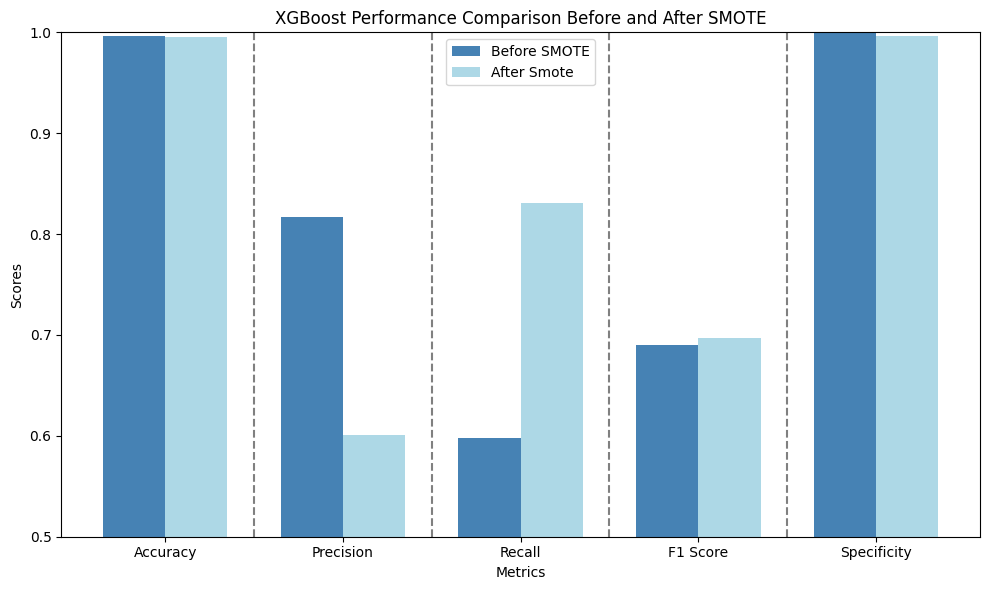

In [ ]:


# Define a function to calculate specificity
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    specificity = tn / (tn + fp)
    return specificity

# Load the XGBoost models
xgb_before_smote = joblib.load('/content/drive/MyDrive/saved_models/xgboost_best_model.pkl')
xgb_after_smote = joblib.load('/content/drive/MyDrive/saved_models/xgboost_best_model_smote.pkl')

# Generate predictions
y_pred_before = xgb_before_smote.predict(X_test)
y_pred_after = xgb_after_smote.predict(X_test_processed)

# Calculate metrics for before SMOTE
metrics_before = [
    accuracy_score(y_test, y_pred_before),
    precision_score(y_test, y_pred_before),
    recall_score(y_test, y_pred_before),
    f1_score(y_test, y_pred_before),
    specificity_score(y_test, y_pred_before)
]

# Calculate metrics for after SMOTE
metrics_after = [
    accuracy_score(y_test, y_pred_after),
    precision_score(y_test, y_pred_after),
    recall_score(y_test, y_pred_after),
    f1_score(y_test, y_pred_after),
    specificity_score(y_test, y_pred_after)
]

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity']
x = np.arange(len(metrics_names))

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35

# Bars for metrics before and after SMOTE
bars1 = ax.bar(x - bar_width/2, metrics_before, bar_width, label='Before SMOTE', color='steelblue')
bars2 = ax.bar(x + bar_width/2, metrics_after, bar_width, label='After Smote', color='lightblue')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('XGBoost Performance Comparison Before and After SMOTE')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.set_ylim([0.5, 1])
ax.legend()

# Adding gridlines for visual separation
for i in range(len(metrics_names) - 1):
    ax.axvline(x=i + 0.5, color='grey', linestyle='--')

plt.tight_layout()
plt.show()


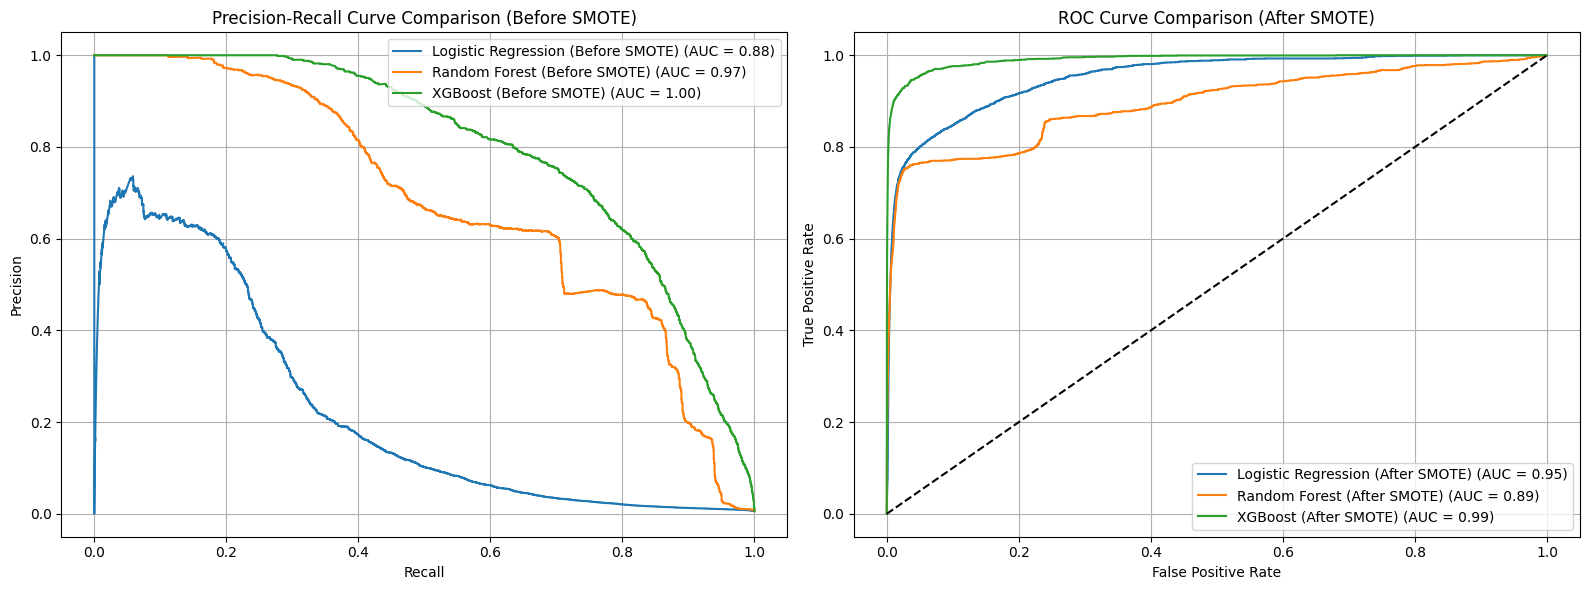

In [ ]:
import pickle
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc

# Define the model paths
model_paths = {
    'logistic_regression_before_smote': '/content/drive/MyDrive/saved_models/logistic_regression_best_model.pkl',
    'random_forest_before_smote': '/content/drive/MyDrive/saved_models/random_forest_best_model.pkl',
    'xgboost_before_smote': '/content/drive/MyDrive/saved_models/xgboost_best_model.pkl',
    'logistic_regression_after_smote': '/content/drive/MyDrive/saved_models/logistic_best_model_smote.pkl',
    'random_forest_after_smote': '/content/drive/MyDrive/saved_models/randomforest_best_model_smote.pkl',
    'xgboost_after_smote': '/content/drive/MyDrive/saved_models/xgboost_best_model_smote.pkl'
}

# Helper function to load model and predict probabilities
def load_and_predict(model_path, X, use_joblib=False):
    if use_joblib:
        model = joblib.load(model_path)
    else:
        model = pickle.load(open(model_path, 'rb'))
    return model.predict_proba(X)[:, 1]

# Plot precision-recall curve
def plot_precision_recall(y_test, y_probs, labels, title):
    plt.figure(figsize=(10, 8))
    for i, y_prob in enumerate(y_probs):
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)
        plt.plot(recall, precision, label=f'{labels[i]} (AUC = {auc_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.grid(True)

# Plot ROC curve
def plot_roc_curve(y_test, y_probs, labels, title):
    plt.figure(figsize=(10, 8))
    for i, y_prob in enumerate(y_probs):
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)

# Get predictions for SMOTE before (using pickle)
y_probs_before = [
    load_and_predict(model_paths['logistic_regression_before_smote'], X_test),
    load_and_predict(model_paths['random_forest_before_smote'], X_test),
    load_and_predict(model_paths['xgboost_before_smote'], X_test)
]
labels_before = ['Logistic Regression (Before SMOTE)', 'Random Forest (Before SMOTE)', 'XGBoost (Before SMOTE)']

# Get predictions for SMOTE after (using joblib)
y_probs_after = [
    load_and_predict(model_paths['logistic_regression_after_smote'], X_test_processed, use_joblib=True),
    load_and_predict(model_paths['random_forest_after_smote'], X_test_processed, use_joblib=True),
    load_and_predict(model_paths['xgboost_after_smote'], X_test_processed, use_joblib=True)
]
labels_after = ['Logistic Regression (After SMOTE)', 'Random Forest (After SMOTE)', 'XGBoost (After SMOTE)']
# Create a single figure with two subplots for side-by-side display
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Precision-Recall curve (before SMOTE)
for i, y_prob in enumerate(y_probs_before):
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    axes[0].plot(recall, precision, label=f'{labels_before[i]} (AUC = {auc_score:.2f})')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve Comparison (Before SMOTE)')
axes[0].legend()
axes[0].grid(True)

# Plot ROC curve (after SMOTE)
for i, y_prob in enumerate(y_probs_after):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f'{labels_after[i]} (AUC = {auc_score:.2f})')
axes[1].plot([0, 1], [0, 1], 'k--')  # Diagonal line
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve Comparison (After SMOTE)')
axes[1].legend(loc='lower right')
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Comparision Between Different Techiniques

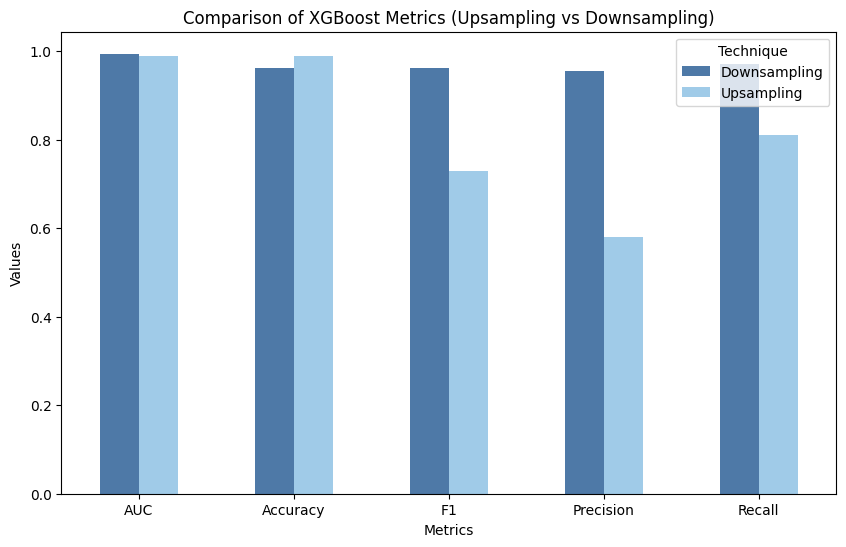

In [ ]:


file_path = '/content/drive/MyDrive/saved_models/results_comparison.xlsx'
data = pd.read_excel(file_path, engine='openpyxl')  # 使用 read_excel 读取 .xlsx 文件

# Filter data for XGBoost Classifier only
xgboost_data = data[['Metrics', 'XGBoost Classifier', 'Technique']]
xgboost_data = xgboost_data.pivot(index='Metrics', columns='Technique', values='XGBoost Classifier')

# Plot bar chart for comparison with Tableau-like colors
xgboost_data.plot(kind='bar', figsize=(10, 6), color=['#4e79a7', '#a0cbe8'])
plt.title("Comparison of XGBoost Metrics (Upsampling vs Downsampling)")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.legend(title="Technique")
plt.xticks(rotation=0)
plt.show()


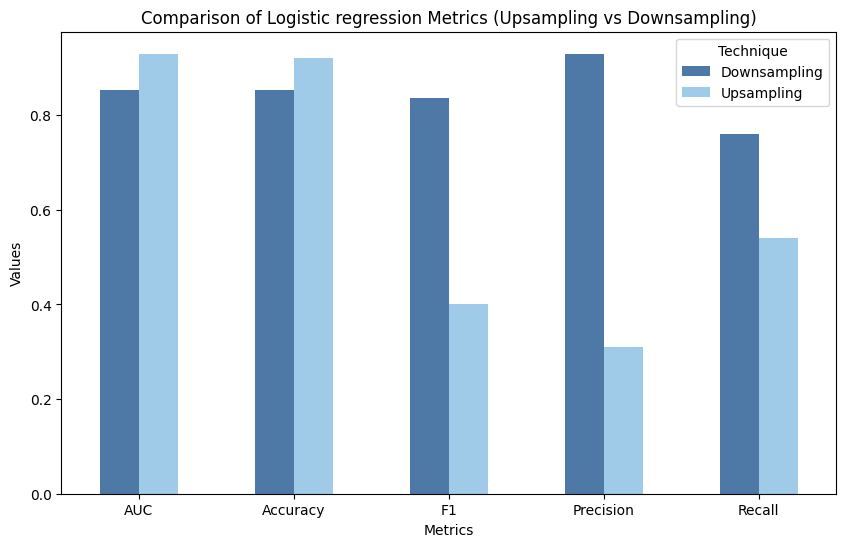

In [ ]:
file_path = '/content/drive/MyDrive/saved_models/results_comparison.xlsx'
data = pd.read_excel(file_path, engine='openpyxl')

# Filter data for XGBoost Classifier only
xgboost_data = data[['Metrics', 'Logistic regression', 'Technique']]
xgboost_data = xgboost_data.pivot(index='Metrics', columns='Technique', values='Logistic regression')

# Plot bar chart for comparison with Tableau-like colors
xgboost_data.plot(kind='bar', figsize=(10, 6), color=['#4e79a7', '#a0cbe8'])
plt.title("Comparison of Logistic regression Metrics (Upsampling vs Downsampling)")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.legend(title="Technique")
plt.xticks(rotation=0)
plt.show()


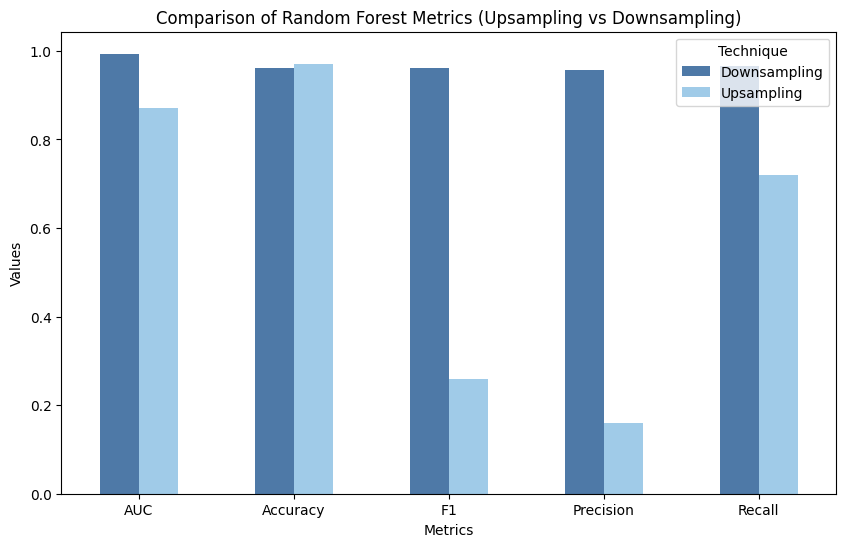

In [ ]:
file_path = '/content/drive/MyDrive/saved_models/results_comparison.xlsx'
data = pd.read_excel(file_path, engine='openpyxl')

# Filter data for XGBoost Classifier only
xgboost_data = data[['Metrics', 'Random Forest Classifier', 'Technique']]
xgboost_data = xgboost_data.pivot(index='Metrics', columns='Technique', values='Random Forest Classifier')

# Plot bar chart for comparison with Tableau-like colors
xgboost_data.plot(kind='bar', figsize=(10, 6), color=['#4e79a7', '#a0cbe8'])
plt.title("Comparison of Random Forest Metrics (Upsampling vs Downsampling)")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.legend(title="Technique")
plt.xticks(rotation=0)
plt.show()